### LJ potential
This notebook shows examples of how to build a neural network `model` for lennard-jones potential and a `trainer` which consume _energy_ and _force components (gradients)_ to fit the model. 

A neural network performs well when interpolating but NOT when extrapolating (increase the factor argument get_position()).

In [1]:
import math
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import matplotlib.style
import matplotlib as mpl
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(2022)
np.random.seed(2022)
mpl.style.use('default') # 'classic'
mpl.style.use('bmh')

In [2]:
def gradient(y, x, grad_outputs=None):
    """
    Compute dy/dx @ grad_outputs
    Ref: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/14
    """
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
        grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True)[0]
    return grad

### Model

In [9]:
class NeuralNetwork(nn.Module):
    """
    A dense neural network.
    """
    def __init__(self, input_size=3):
        super(NeuralNetwork, self).__init__()
        self.layer_stack = nn.Sequential(
          nn.Linear(input_size, 10),
          nn.Tanh(),
          nn.Linear(10, 10),
          nn.Tanh(),
          nn.Linear(10, 1),
          nn.Identity(),
        )

    def forward(self, x):
        return self.layer_stack(x)
    
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Identity()
  )
)


In [10]:
def potential(x, sigma=1.1, epsilon=2.0):
    tmp6 = torch.pow(sigma/torch.norm(x, dim=1), 6)
    return (4.0*epsilon*(tmp6*tmp6 - tmp6)).view(-1, 1)

def get_position(n, requires_grad=True, factor=1.2):
    return torch.rand(n, 3, requires_grad=requires_grad) * factor + 0.6
#     return (torch.normal(mean=0.8, std=1.0, size=(n, 3), requires_grad=requires_grad)) * factor + 0.7

pos = get_position(5000)   # energy samples
eng = potential(pos)
pos_ = get_position(5000) # force samples
eng_ = potential(pos_)
frc = gradient(eng_, pos_)

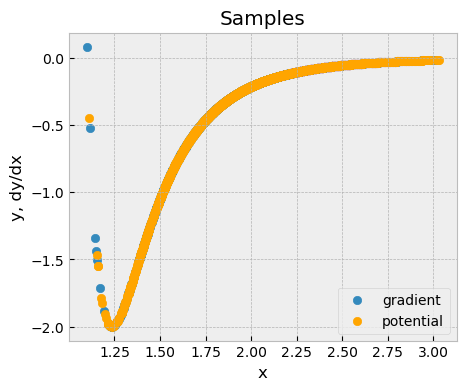

In [11]:
plt.subplots(figsize=(5, 4))
plt.scatter(torch.norm(pos_, dim=1).detach().numpy(), eng_.detach().numpy(), label="gradient")
plt.scatter(torch.norm(pos, dim=1).detach().numpy(), eng.detach().numpy(), label="potential", color="orange")
plt.xlabel("x"); plt.ylabel("y, dy/dx"); plt.legend(loc='lower right'); plt.title("Samples");

In [12]:
class EnergyDataLoader(Dataset):
    """
    Energy specific DataLoader.
    """
    def __init__(self, position=pos, energy=eng):
        self.position = position
        self.energy = energy

    def __len__(self):
        return len(self.energy)

    def __getitem__(self, idx):
        return {"energy": self.energy[idx, ...], "position": self.position[idx, ...]}
                 
                 
class ForceDataLoader(Dataset):
    """
    Force specific DataLoader.
    """
    def __init__(self, position=pos_, force=frc):
        self.position = position
        self.force = force

    def __len__(self):
        return len(self.force)

    def __getitem__(self, idx):
        return {"force": self.force[idx, ...], "position": self.position[idx, ...]}
    

energy_loader = DataLoader(EnergyDataLoader(), batch_size=100, shuffle=True)
force_loader = DataLoader(ForceDataLoader(), batch_size=500, shuffle=True)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

def train(model, optimizer, loss_fn, epochs=500):
    """
    Train input model using provided optimizer, loss function, and data loader (energy amd forces).
    """
    print(f"Energy update ratio: {len(force_loader)/float(len(energy_loader)):.2f} ({len(force_loader)}/{len(energy_loader)})")
    energy_loader_ = iter(energy_loader)
    
    for epoch in range(epochs):
        strout = f"Epoch: [{epoch+1:4}/{epochs:4}]"
        
        # Training 
        training_eng_loss = 0.0
        training_frc_loss = 0.0
        model.train()
        nbatch = 0
        # Loop over force batches
        for index, fbatch in enumerate(force_loader):
            # Reset gradients
            optimizer.zero_grad()
            # Get next energy batch (infinite loader)
            try:
                ebatch = next(energy_loader_)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader 
                #print("Infinite loop")
                energy_loader_ = iter(energy_loader)
                ebatch = next(energy_loader_)
            # Energy    
            eng_ =  model(ebatch["position"])
            eng_loss = criterion(eng_, ebatch["energy"]) 
            # Force
            eng_ = model(fbatch['position'])
            frc_ = gradient(eng_, fbatch['position'])
            frc_loss = criterion(frc_, fbatch['force'])
            # update weights
            loss = eng_loss + frc_loss
            loss.backward(retain_graph=True)
            optimizer.step()
            # Accumulate loss values
            training_eng_loss += eng_loss.data.item()
            training_frc_loss += frc_loss.data.item()
            nbatch += 1
            #print(nbatch, ebatch['energy'].shape, fbatch['force'].shape)
        #assert len(force_loader) > len(energy_loader)
        training_eng_loss /= nbatch
        training_frc_loss /= nbatch
        training_loss = training_eng_loss + training_frc_loss
        strout += f", Training Loss: {training_loss:.8f} <force({training_frc_loss:.8f}), energy({training_eng_loss:.8f})>"
        
        # Validation
        valid_loss = 0.0
        model.eval()
        pos_val = get_position(1000)
        eng_val = potential(pos_val)
        frc_val = gradient(eng_val, pos_val)
        eng_ =  model(pos_val)
        frc_ = gradient(eng_, pos_val)
        loss = criterion(eng_val, eng_) + criterion(frc_val, frc_)
        valid_loss += loss.data.item()
        strout += f", Validation Loss: {valid_loss:.8f}"

        if epoch==0 or (epoch+1) % 100 == 0:
            print(strout)
        

In [17]:
train(model, optimizer, criterion)

Energy update ratio: 0.20 (10/50)
Epoch: [   1/ 500], Training Loss: 0.00354707 <force(0.00292390), energy(0.00062317)>, Validation Loss: 0.00411448
Epoch: [ 100/ 500], Training Loss: 0.00237107 <force(0.00217554), energy(0.00019553)>, Validation Loss: 0.00267543
Epoch: [ 200/ 500], Training Loss: 0.00123902 <force(0.00120040), energy(0.00003862)>, Validation Loss: 0.00241231
Epoch: [ 300/ 500], Training Loss: 0.00173908 <force(0.00133637), energy(0.00040271)>, Validation Loss: 0.00140928
Epoch: [ 400/ 500], Training Loss: 0.00142167 <force(0.00121461), energy(0.00020706)>, Validation Loss: 0.00163930
Epoch: [ 500/ 500], Training Loss: 0.00124997 <force(0.00120701), energy(0.00004296)>, Validation Loss: 0.00143658


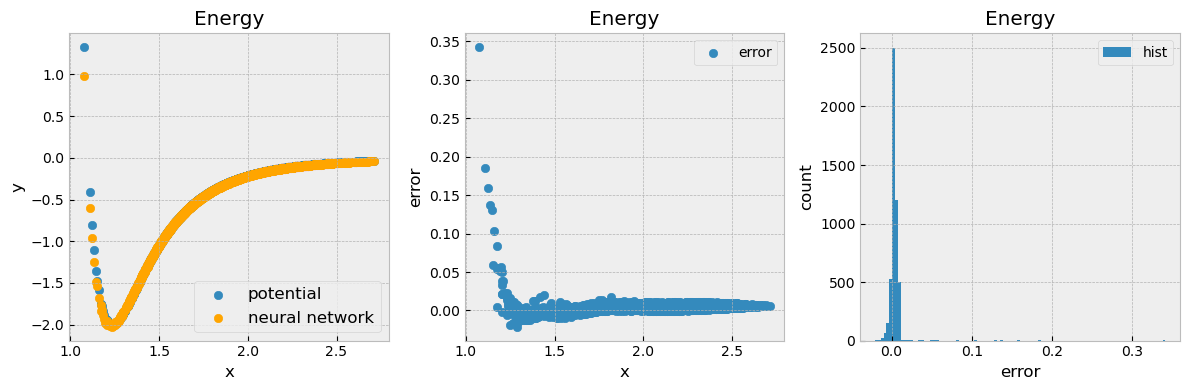

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

pos = get_position(5000, factor=1)
x = torch.norm(pos, dim=1).detach().numpy()
y_true = potential(pos).detach().numpy()
y_pred = model(pos).detach().numpy()

ax[0].scatter(x, y_true, label="potential")
ax[0].scatter(x, y_pred, label="neural network", color="orange")
ax[0].set_xlabel("x"); ax[0].set_ylabel("y"); ax[0].legend(loc="lower right", fontsize=12); ax[0].set_title("Energy");

err = y_true - y_pred
ax[1].scatter(x, err, label="error");
ax[1].set_xlabel("x"); ax[1].set_ylabel("error"); ax[1].legend(); ax[1].set_title("Energy");
ax[2].hist(err, bins=100, label="hist");
ax[2].set_xlabel("error"); ax[2].set_ylabel("count"); ax[2].legend(); ax[2].set_title("Energy");
plt.tight_layout()

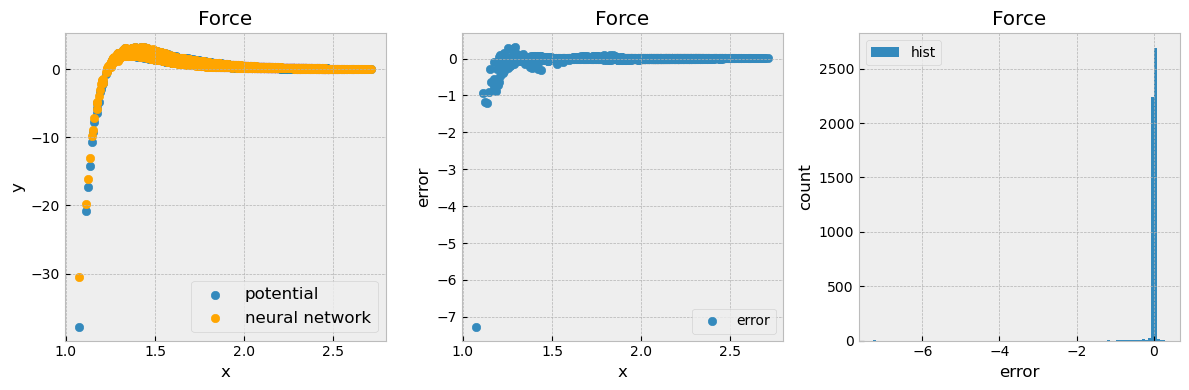

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# pos = get_position(5000, factor=1)
x = torch.norm(pos, dim=1).detach().numpy()
y_true = gradient(potential(pos), pos)[:, 0].detach().numpy()
y_pred = gradient(model(pos), pos)[:, 0].detach().numpy()

ax[0].scatter(x, y_true, label="potential")
ax[0].scatter(x, y_pred, label="neural network", color='orange')
ax[0].set_xlabel("x"); ax[0].set_ylabel("y"); ax[0].legend(loc="lower right", fontsize=12); ax[0].set_title("Force");

err = y_true - y_pred
ax[1].scatter(x, err, label="error");
ax[1].set_xlabel("x"); ax[1].set_ylabel("error"); ax[1].legend(); ax[1].set_title("Force");
ax[2].hist(err, bins=100, label="hist");
ax[2].set_xlabel("error"); ax[2].set_ylabel("count"); ax[2].legend(); ax[2].set_title("Force");
plt.tight_layout()